In [1]:
import os
import skimage.io as io
import matplotlib.pyplot as plt
import random
from PIL import Image

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from improved_unet import *
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow_addons.layers import InstanceNormalization
from keras.models import Model, model_from_json
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model

Using TensorFlow backend.


In [2]:
import cv2
import glob

# Load data

In [3]:
images = []
for img in glob.glob("ISIC2018_Task1-2_Training_Data\ISIC2018_Task1-2_Training_Input_x2/*.jpg"):
    n= cv2.imread(img,1)
    images.append(n)

In [4]:
masks = []
for img in glob.glob("ISIC2018_Task1-2_Training_Data\ISIC2018_Task1_Training_GroundTruth_x2/*.png"):
    m= cv2.imread(img,0)
    masks.append(m)

Resize image to 256x256 and create two array for preparation of dataset spliting.

In [5]:
image_size = (256,256)

In [6]:
for i in range(len(images)):
    images[i] = cv2.resize(images[i],image_size,interpolation = cv2.INTER_CUBIC)
    images[i] = images[i]/255
for i in range(len(masks)):
    masks[i] = cv2.resize(masks[i],image_size,interpolation = cv2.INTER_CUBIC)
    masks[i] = np.round(masks[i]/255,0)

In [7]:
X = np.zeros([2594, 256, 256, 3])
y = np.zeros([2594, 256, 256])

In [8]:
for i in range(len(images)):
    X[i] = images[i]
    
for i in range(len(masks)):
    y[i] = masks[i]
        
y = y[:, :, :, np.newaxis]

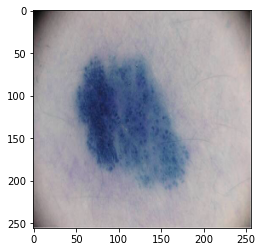

In [9]:
plt.imshow(X[7])

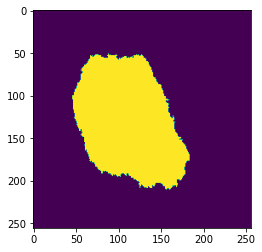

In [10]:
plt.imshow(y[7])

split into train, validatate and test

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.7, random_state=7)
X_test, X_val, Y_test, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=7)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(Y_val.shape)
print(X_val.shape)

(1815, 256, 256, 3)
(1270, 256, 256, 3)
(545, 256, 256, 1)
(545, 256, 256, 3)


dice coefficient function and coefficient loss function

In [13]:
def dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(tf.math.multiply(y_true, y_pred))
    dsc = 2*intersection / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))
    return dsc

In [14]:
def dsc_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)

# build and training model 

In [15]:
model = improved_unet(256, 256, 3)

In [16]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 16) 32          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        instance_normalization[0][0]     
_______________________________________________________________________________________

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient, 'accuracy'])

In [18]:
history = model.fit(x = X_train, y=Y_train, epochs=25, validation_data=(X_val, Y_val), verbose=1, batch_size = 16)

Epoch 1/25
114/114 [==============================] - 25s 223ms/step - loss: 0.3231 - dice_coefficient: 0.5480 - accuracy: 0.8822 - val_loss: 0.2623 - val_dice_coefficient: 0.6793 - val_accuracy: 0.9090
Epoch 2/25
114/114 [==============================] - 24s 213ms/step - loss: 0.2130 - dice_coefficient: 0.7075 - accuracy: 0.9182 - val_loss: 0.2066 - val_dice_coefficient: 0.7787 - val_accuracy: 0.9226
Epoch 3/25
114/114 [==============================] - 24s 207ms/step - loss: 0.1908 - dice_coefficient: 0.7379 - accuracy: 0.9260 - val_loss: 0.1730 - val_dice_coefficient: 0.7744 - val_accuracy: 0.9288
Epoch 4/25
114/114 [==============================] - 24s 206ms/step - loss: 0.1769 - dice_coefficient: 0.7591 - accuracy: 0.9302 - val_loss: 0.1782 - val_dice_coefficient: 0.7814 - val_accuracy: 0.9271
Epoch 5/25
114/114 [==============================] - 23s 204ms/step - loss: 0.1606 - dice_coefficient: 0.7825 - accuracy: 0.9370 - val_loss: 0.1581 - val_dice_coefficient: 0.8162 - val_ac

# plot training history

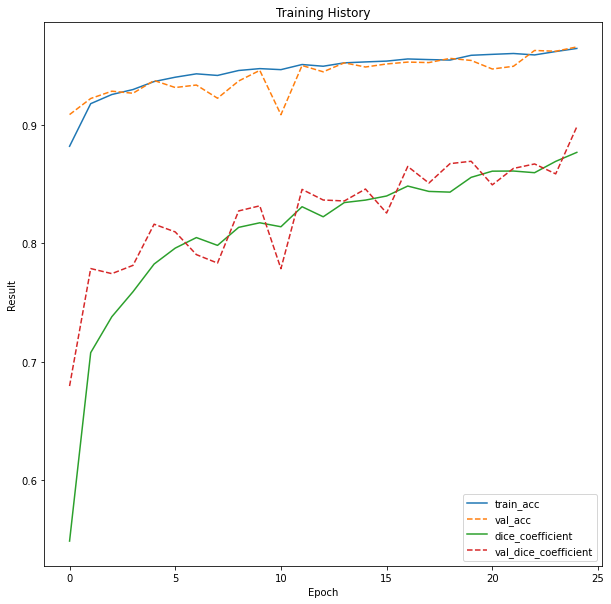

In [19]:
plt.figure(figsize= (10,10))
plt.plot(history.history['accuracy'], label = 'train_acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc', linestyle='dashed')
plt.plot(history.history['dice_coefficient'], label = 'dice_coefficient')
plt.plot(history.history['val_dice_coefficient'], label = 'val_dice_coefficient', linestyle='dashed')
plt.title('Training History')
plt.ylabel('Result')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

get average dice coefficient

In [23]:
dsc = list()
for i in range(1):
    dsc += history.history['dice_coefficient']
print ("Average DSC:", sum(dsc)/25)    

Average DSC: 0.8105851316452026


plot predicition

In [21]:
predictions = model.predict(X_test)
for i in range(len(predictions)):
    predictions[i]=np.round(predictions[i],0)

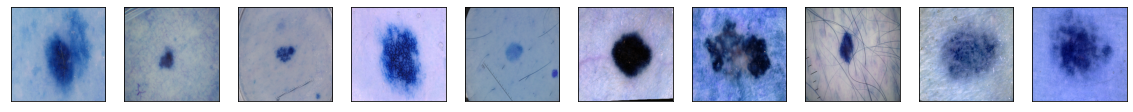

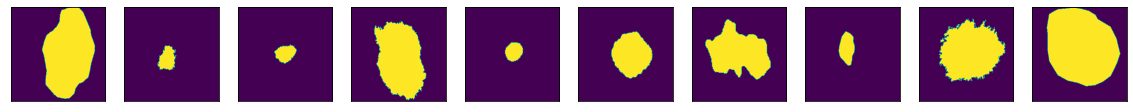

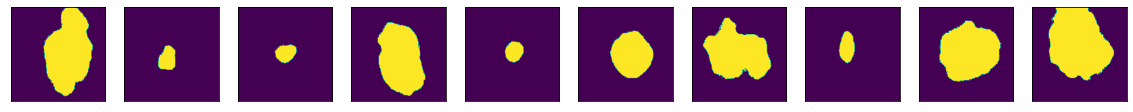

In [22]:
n = 10 
plt.figure(figsize=(20, 20))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.figure(figsize=(20, 20))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(Y_test[i],)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.figure(figsize=(20, 20))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(predictions[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)